In [1]:
%matplotlib inline

In [20]:
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split

In [3]:
ds_root = Path('./datasets/rtsd-r3')

In [4]:
train_df = pd.read_csv(ds_root / 'gt_train.csv')
train_df['filename'] = 'train/' + train_df['filename']
val_df = pd.read_csv(ds_root / 'gt_test.csv')
val_df['filename'] = 'test/' + val_df['filename']

df = pd.concat([train_df, val_df], axis=0)
del train_df, val_df

labels_df = pd.read_csv(ds_root / 'numbers_to_classes.csv')
df = pd.merge(df, labels_df, on='class_number', how='outer', validate='many_to_one', copy=False)
del labels_df

df.columns = ['image_path', 'label_id', 'label']
df.head()

,image_path,label_id,label
0,train/000000.png,24,2_1
1,train/000001.png,24,2_1
2,train/000002.png,24,2_1
3,train/000003.png,24,2_1
4,train/000005.png,24,2_1


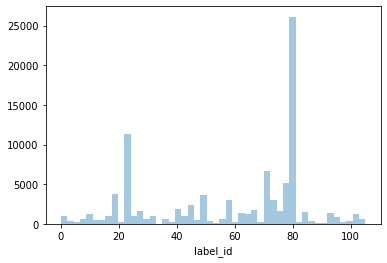

In [5]:
sns.distplot(df['label_id'], kde=False);

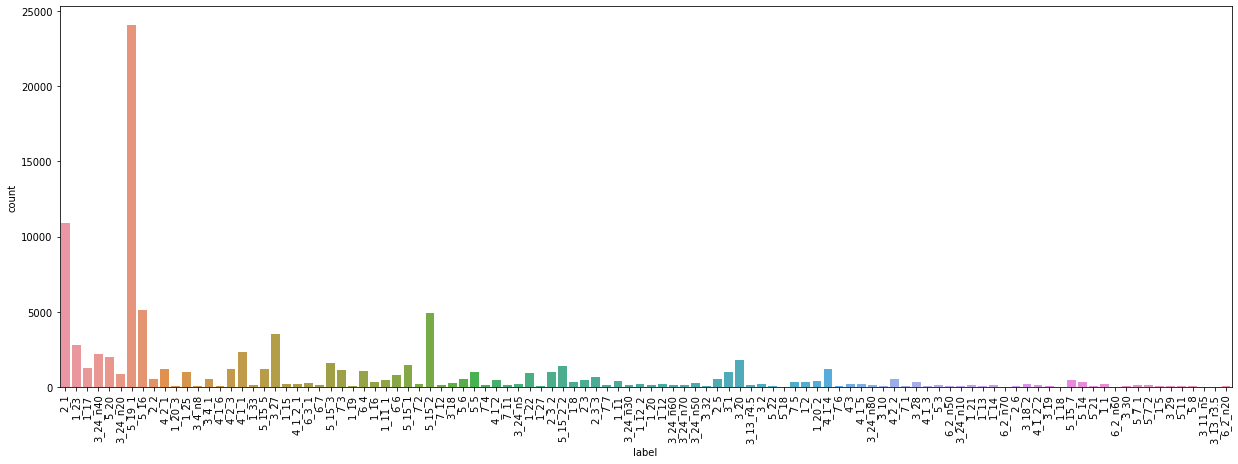

In [10]:
_, ax = plt.subplots(figsize=(21, 7))
plt.xticks(rotation=90)
sns.countplot(x='label', data=df, ax=ax);

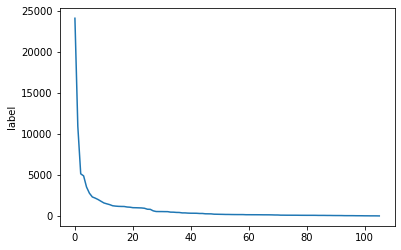

In [17]:
vc = df['label'].value_counts().sort_values(ascending=False)
sns.lineplot(np.arange(len(vc)), vc);

In [38]:
train_idx, val_idx = train_test_split(df.index, test_size=0.2, stratify=df['label'], random_state=27)
train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]

In [41]:
vc_tdf = train_df['label'].value_counts().sort_values(ascending=False)
vc_vdf = val_df['label'].value_counts().sort_values(ascending=False)

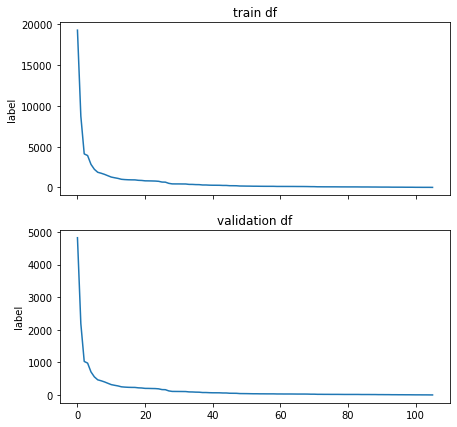

In [55]:
_, ax = plt.subplots(nrows=2, sharex=True, figsize=(7, 7))
sns.lineplot(np.arange(len(vc_tdf)), vc_tdf, ax=ax[0]).set_title('train df')
sns.lineplot(np.arange(len(vc_vdf)), vc_vdf, ax=ax[1]).set_title('validation df');

In [61]:
def trim(df, top_count=2500):
    labels = df['label'].unique()
    result = None
    for label in labels:
        df_chunk = df[df['label'] == label].iloc[:top_count]
        result = df_chunk if result is None else pd.concat([result, df_chunk])
    return result


In [63]:
train_df_trimmed, val_df_trimmed = trim(train_df), trim(val_df)

In [65]:
vc_ttdf = train_df_trimmed['label'].value_counts().sort_values(ascending=False)
vc_vtdf = train_df_trimmed['label'].value_counts().sort_values(ascending=False)

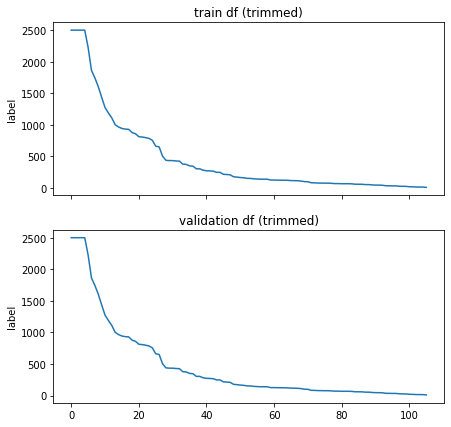

In [66]:
_, ax = plt.subplots(nrows=2, sharex=True, figsize=(7, 7))
sns.lineplot(np.arange(len(vc_ttdf)), vc_ttdf, ax=ax[0]).set_title('train df (trimmed)')
sns.lineplot(np.arange(len(vc_vtdf)), vc_vtdf, ax=ax[1]).set_title('validation df (trimmed)');

In [80]:
new_ds_root = Path('./datasets/rtsd-r3-cut2500')
new_train_root = new_ds_root / 'train'
new_val_root = new_ds_root / 'val'
new_train_root.mkdir(parents=True, exist_ok=True)
new_val_root.mkdir(parents=True, exist_ok=True)

In [83]:
def move(df, to, from_):
    id_counter = 0
    data = []
    for idx, row in df.iterrows():
        fname = f'{id_counter:06}'
        id_counter += 1
        shutil.copyfile(from_ / row['image_path'], to / f'{fname}.png')
        data.append([fname, row['label'], row['label_id']])
    return pd.DataFrame(data, columns=['image_name', 'label', 'label_id'])


In [84]:
train_df_final = move(train_df_trimmed, new_train_root, ds_root)
val_df_final = move(val_df_trimmed, new_val_root, ds_root)

In [85]:
final_df = pd.concat([train_df_final, val_df_final])
final_df.to_csv(new_ds_root / 'labels.csv', index=False)